<h1>Sam Armstrong Assignment 2 CS545</h1>

In [2]:
import numpy as np
import pandas
import optimizers as opt
import matplotlib.pyplot as plt
%matplotlib inline
# import optimizers as opt  # from Lecture Notes

<h2>Matrix Equations</h2>

\begin{align}
N & = \text{number of samples} \\
I & = \text{the number of attributes in each sample} \\
K & = \text{number of units in output layer} \\
H_1 & = \text{number of units in first hidden layer} \\
H_2 & = \text{number of units in second hidden layer} \\
\\
\mathbf{Z}_1 & = \tanh(\hat{\mathbf{X}}\ \mathbf{U}) \\
\mathbf{Z}_2 & = \tanh(\hat{\mathbf{Z}}_1\ \mathbf{V}) \\
\mathbf{Y} & = \hat{\mathbf{Z}}_2\ \mathbf{W} \\
\mathbf{E} & = \frac{1}{NK}\sum_{n=1}^{N}\sum_{k=1}^{K}(\mathbf{T}_{n,k} - \mathbf{Y}_{n,k})^2 \\
\\
\nabla_{\mathbf{Y}}{E_{n,k}} & = \frac{-2}{NK}(\mathbf{T}_{n,k} - \mathbf{Y}_{n,k}) \\
\delta_{\mathbf{Y}} & = \frac{-2}{NK}(\mathbf{T} - \mathbf{Y}) \\
\nabla_{\mathbf{W}}{E} & = \underbrace{\underbrace{\hat{\mathbf{Z}}_2^T}_{H_2+1 \times N} \underbrace{\delta_{\mathbf{Y}}}_{N \times K}}_{H_2+1 \times K} \\
\\
\nabla_{\mathbf{V}}{E} & = \underbrace{\underbrace{\hat{\mathbf{Z}}_1^T}_{H_1+1 \times N} \underbrace{\delta_{\mathbf{Z}_2}}_{N \times H_2}}_{H_1+1 \times H_2} \text{ where } \delta_{\mathbf{Z}_2} = (\delta_{\mathbf{Y}} \mathbf{W}_{1:}^T) \cdot (1-\mathbf{Z}_2^2) \ \text{ if } f(\hat{\mathbf{X}} \mathbf{V}) = \tanh{(\hat{\mathbf{X}} \mathbf{V})} \\
\\
\nabla_{\mathbf{U}}{E} & = \underbrace{\underbrace{\hat{\mathbf{X}}^T}_{I+1 \times N} \underbrace{\delta_{\mathbf{Z}_1}}_{N \times H_1}}_{I+1 \times H_1} \text{ where } \delta_{\mathbf{Z}_1} = (\delta_{\mathbf{Z}_2} \mathbf{V}_{1:}^T) \cdot (1-\mathbf{Z}_1^2) \ \text{ if } f(\hat{\mathbf{X}} \mathbf{V}) = \tanh{(\hat{\mathbf{X}} \mathbf{V})} \\
\end{align}

<h2>Network Function</h2>

In [3]:
def network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, all_outputs=False):
    n_U = (n_inputs + 1) * n_hiddens_1
    n_V = (n_hiddens_1 + 1) * n_hiddens_2
    n_W = (n_hiddens_2 + 1) * n_outputs
    U = w[:n_U].reshape((n_inputs + 1, n_hiddens_1))
    V = w[n_U:(n_U+n_V)].reshape((n_hiddens_1 + 1, n_hiddens_2))
    W = w[(n_U+n_V):].reshape((n_hiddens_2 + 1, n_outputs))
    Z1 = np.tanh(U[0:1, :] + X @ U[1:, :])
    Z2 = np.tanh(V[0:1, :] + Z1 @ V[1:, :])
    Y = W[0:1, :] + Z2 @ W[1:, :]
    return (Y, Z1, Z2) if all_outputs else Y

<h2>Error Gradient Function</h2>

In [4]:
def error_gradient(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T):
    Y, Z1, Z2 = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, all_outputs=True)
    n_samples = X.shape[0]
    delta_Y = -2 / (n_samples * n_outputs) * (T - Y)
    Z2_hat = np.insert(Z2, 0, 1, axis=1)
    dEdW = Z2_hat.T @ delta_Y
    
    n_W = (n_hiddens_2 + 1) * n_outputs
    W = w[-n_W:].reshape((n_hiddens_2 + 1, n_outputs))
    delta_Z2 = (delta_Y @ W[1:, :].T) * (1 - Z2**2)
    Z1_hat = np.insert(Z1, 0, 1, axis=1)
    dEdV = Z1_hat.T @ delta_Z2
    
    n_U = (n_inputs + 1) * n_hiddens_1
    n_V = (n_hiddens_1 + 1) * n_hiddens_2
    V = w[n_U:(n_U+n_V)].reshape((n_hiddens_1 + 1, n_hiddens_2))
    delta_Z1 = (delta_Z2 @ V[1:, :].T) * (1 - Z1**2)
    X_hat = np.insert(X, 0, 1, axis=1)
    dEdU = X_hat.T @ delta_Z1
 
    dEdw = np.hstack((dEdU.flatten(), dEdV.flatten(), dEdW.flatten()))

    return dEdw

<h2>Mean Squared Error Function</h2>

In [5]:
def mse(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T):
    Y = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X)
    return np.mean((T - Y)**2)

<h2>Import Data</h2>

In [6]:
data = pandas.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', usecols=range(15), na_values=-200)
data = data[['Time', 'CO(GT)']]
data = data [:23 * 20]  # first 20 days of data
data = data.dropna(axis=0)
print('data.shape =', data.shape)

hour = [int(t[:2]) for t in data['Time']]
X = np.array(hour).reshape(-1, 1)
CO = data['CO(GT)']
T = np.array(CO).reshape(-1, 1)
np.hstack((X, T))[:10]  # show the first 10 samples of hour, CO

data.shape = (443, 2)


array([[18. ,  2.6],
       [19. ,  2. ],
       [20. ,  2.2],
       [21. ,  2.2],
       [22. ,  1.6],
       [23. ,  1.2],
       [ 0. ,  1.2],
       [ 1. ,  1. ],
       [ 2. ,  0.9],
       [ 3. ,  0.6]])

<h2>Define the Network Parameters</h2>

In [7]:
n_inputs = X.shape[1]
n_hiddens_1 = 5
n_hiddens_2 = 5
n_outputs = T.shape[1]

<h2>Intialize Weight Vector</h2>

In [8]:
n_U = (n_inputs + 1) * n_hiddens_1
n_V = (n_hiddens_1 + 1) * n_hiddens_2
n_W = (n_hiddens_2 + 1) * n_outputs

initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)  # range of weights is -0.1 to 0.1

<h2>Standardize the Input Values</h2>

In [9]:
standardize = True

if standardize:
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    
    X = (X - X_mean) / X_std
    
print(f'X mean is {X.mean(axis=0)[0]:.3f} and its standard deviation is {X.std(axis=0)[0]:.3f}')

X mean is 0.000 and its standard deviation is 1.000


<h2>Train Network with Three Optimization Algorithms</h2>

In [10]:
n_iterations = 2000

result_sgd = opt.sgd(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations, learning_rate=1e-1, momentum_rate=0.2, 
                     save_wtrace=True)
print(f'SGD final error is {result_sgd["ftrace"][-1]:.3f} and it took {result_sgd["time"]:.2f} seconds')

result_adam = opt.adam(initial_w, 
                       mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                       n_iterations=n_iterations, learning_rate=1e-2, 
                       save_wtrace=True)
print(f'Adam final error is {result_adam["ftrace"][-1]:.3f} and it took {result_adam["time"]:.2f} seconds')

result_scg = opt.scg(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations,
                     save_wtrace=True)
print(f'SCG final error is {result_scg["ftrace"][-1]:.3f} and it took {result_scg["time"]:.2f} seconds')

SGD final error is 1.153 and it took 0.96 seconds
Adam final error is 0.913 and it took 1.04 seconds
SCG final error is 0.912 and it took 2.11 seconds


<h2>Plot Error Curves and Model Fits</h2>

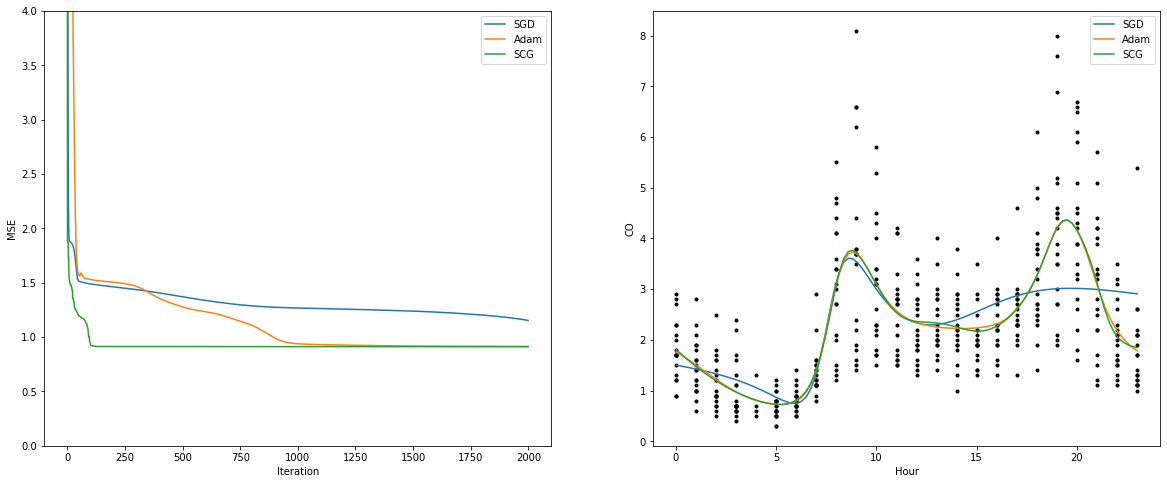

In [11]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(result_sgd['ftrace'], label='SGD')
plt.plot(result_adam['ftrace'], label='Adam')
plt.plot(result_scg['ftrace'], label='SCG')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.ylim(0, 4)

plt.subplot(1, 2, 2)
if standardize:
    plt.plot(((X * X_std) + X_mean), T, 'k.')  # unstandardize X
else:
    plt.plot(X, T, 'k.')
xs = np.linspace(0, 23, 100).reshape((-1, 1))
xs_standardized = (xs - X_mean) / X_std if standardize else xs
plt.plot(xs, network(result_sgd['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized), label='SGD')
plt.plot(xs, network(result_adam['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized), label='Adam')
plt.plot(xs, network(result_scg['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized), label='SCG')
plt.legend()
plt.xlabel('Hour')
plt.ylabel('CO');

<h3>Discussion</h3>
SCG performs the best with a MSE of 0.912. SCG is also the slowest running with a 2.05 second runtime. The SCG line in the Iterations by MSE graph drops the quickest and goes horizontal at about 250 iterations, showing SCG performs the best within a small amount of iterations. Adam performs the second best with a MSE 0.913. Adam is also the second quickest to run at 1.02 seconds. The Adam line goes horizontal at about 1250 iterations showing Adam performs about the same at 1250 iterations as SCG performs at 250 iterations. The SGD performs the worse with a MSE of 0.988. SGD has the quickest run time of 0.97 seconds. Although SGD performs the worst its line in the Iterations by MSE is still dropping which indicates it needs more iterations than 2000 before it's line becomes horizontal. The lines in the Hour by CO graph are very similar for all three (SCG, Adam, SGD) which makes sense since all three have very close MSE and have identical inputs.

<h2>Find Best Parameters for n_iterations, n_hiddens_1, n_hiddens_2 and learning_rate</h2>
<h3>*This Takes a While to Run (~1 hour)</h3>

In [11]:
results = []
for n_iterations in [2000, 3000, 4000]:
    print("Iterations for " + str(n_iterations))
    for nh1 in [10, 11, 12, 13, 14, 15]:
        for nh2 in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
            n_U = (n_inputs + 1) * nh1
            n_V = (nh1 + 1) * nh2
            n_W = (nh2 + 1) * n_outputs
            initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)

            result_scg = opt.scg(initial_w, mse, error_gradient, fargs=[n_inputs, nh1, nh2, n_outputs, X, T],
                                 n_iterations=n_iterations)
            
            results.append([n_iterations, nh1, nh2, "N/A", 'scg', result_scg['ftrace'][-1]])
            
            for lr in [1e-1, 1e-2]:
                result_sgd = opt.sgd(initial_w, mse, error_gradient, fargs=[n_inputs, nh1, nh2, n_outputs, X, T],
                     n_iterations=n_iterations, learning_rate=lr, momentum_rate=0)
                result_adam = opt.adam(initial_w, mse, error_gradient, fargs=[n_inputs, nh1, nh2, n_outputs, X, T],
                                       n_iterations=n_iterations, learning_rate=lr)
                
                
                results.append([n_iterations, nh1, nh2, lr, 'sgd', result_sgd['ftrace'][-1]])
                results.append([n_iterations, nh1, nh2, lr, 'adam', result_adam['ftrace'][-1]])
        print(str(round((((nh1 - 9)/6)*100), 2)) + "%")
results = pandas.DataFrame(results, columns=('Iterations', 'nh1', 'nh2', 'lr', 'algo', 'mse'))
results.sort_values('mse').head(20)

Iterations for 2000
16.67%
33.33%
50.0%
66.67%
83.33%
100.0%
Iterations for 3000
16.67%
33.33%
50.0%
66.67%
83.33%
100.0%
Iterations for 4000
16.67%
33.33%
50.0%
66.67%
83.33%
100.0%


,Iterations,nh1,nh2,lr,algo,mse
570,3000,11,10,N/A,scg,0.909626
1345,4000,15,15,N/A,scg,0.909626
1260,4000,14,13,N/A,scg,0.909626
960,4000,10,13,N/A,scg,0.909626
1197,4000,13,15,0.1,adam,0.909626
1180,4000,13,12,N/A,scg,0.909630
1035,4000,11,13,N/A,scg,0.909631
1040,4000,11,14,N/A,scg,0.909632
725,3000,13,11,N/A,scg,0.909633
1105,4000,12,12,N/A,scg,0.909638


<h3>SCG Results</h3>

In [12]:
scg_results = results[results['algo'] =='scg'].sort_values('mse').head(20)
scg_results

,Iterations,nh1,nh2,lr,algo,mse
570,3000,11,10,N/A,scg,0.909626
1345,4000,15,15,N/A,scg,0.909626
1260,4000,14,13,N/A,scg,0.909626
960,4000,10,13,N/A,scg,0.909626
1180,4000,13,12,N/A,scg,0.909630
1035,4000,11,13,N/A,scg,0.909631
1040,4000,11,14,N/A,scg,0.909632
725,3000,13,11,N/A,scg,0.909633
1105,4000,12,12,N/A,scg,0.909638
1045,4000,11,15,N/A,scg,0.909639


<h3>SGD Results</h3>

In [13]:
sgd_results = results[results['algo'] =='sgd'].sort_values('mse').head(20)
sgd_results

,Iterations,nh1,nh2,lr,algo,mse
1301,4000,15,6,0.1,sgd,0.913186
1306,4000,15,7,0.1,sgd,0.913230
1246,4000,14,10,0.1,sgd,0.913286
1161,4000,13,8,0.1,sgd,0.913290
1166,4000,13,9,0.1,sgd,0.913396
1316,4000,15,9,0.1,sgd,0.913417
1076,4000,12,6,0.1,sgd,0.913489
1226,4000,14,6,0.1,sgd,0.913634
931,4000,10,7,0.1,sgd,0.913667
1311,4000,15,8,0.1,sgd,0.913673


<h3>Adam Results</h3>

In [14]:
adam_results = results[results['algo'] =='adam'].sort_values('mse').head(20)
adam_results

,Iterations,nh1,nh2,lr,algo,mse
1197,4000,13,15,0.1,adam,0.909626
672,3000,12,15,0.1,adam,0.909642
822,3000,14,15,0.1,adam,0.909646
292,2000,13,14,0.1,adam,0.909677
727,3000,13,11,0.1,adam,0.909704
582,3000,11,12,0.1,adam,0.909705
1012,4000,11,8,0.1,adam,0.909735
817,3000,14,14,0.1,adam,0.909753
1269,4000,14,14,0.01,adam,0.909786
372,2000,14,15,0.1,adam,0.909792


<h3>Discussion</h3>
The range for n_iterations was [2000, 3000, 4000], the range for nh1 was [10, 11, 12, 13, 14, 15], the range for nh2 was [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], and the range for lr was [1e-1, 1e-2]. Adam performed the best with an MSE of 0 (less than 1e-35) in 2000 iterations, a learning rate of 0.01, a first hidden layer of 14, and a second hidden layer of 8. SCG performed the second best with an MSE of 7.167041e-19 in 3000 iterations, a first hidden layer of 12, and a second hidden layer of 15. SGD performed the worse with an MSE of 3.423091e-11 in 4000 iterations, a learning rate of 0.1, a first hidden layer of 13, and a second hidden layer of 2.

<h2>5 Samples and 2 Outputs</h2>

In [24]:
X = np.arange(15).reshape((5, 3))
T = np.hstack((X[:, 0:1] * 0.1 * X[:, 1:2], X[:, 2:]**2)) # making two target values for each sample
T = T.reshape((5, 2))
print('  Input            Target')
for x, t in zip(X, T):
    print(x, '\t', t)

  Input            Target
[0 1 2] 	 [0. 4.]
[3 4 5] 	 [ 1.2 25. ]
[6 7 8] 	 [ 4.2 64. ]
[ 9 10 11] 	 [  9. 121.]
[12 13 14] 	 [ 15.6 196. ]


<h2>50 Units Hidden Layer 1 and 3 Units Hidden Layer 2</h2>

In [19]:
n_hiddens_1 = 50
n_hiddens_2 = 3
n_iterations = 1000


n_inputs = X.shape[1]
n_outputs = T.shape[1]

n_U = (n_inputs + 1) * n_hiddens_1
n_V = (n_hiddens_1 + 1) * n_hiddens_2
n_W = (n_hiddens_2 + 1) * n_outputs

initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)  # range of weights is -0.1 to 0.1

result_sgd = opt.sgd(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations, learning_rate=1e-1, momentum_rate=0.2, 
                     save_wtrace=True)
print(f'SGD final error is {result_sgd["ftrace"][-1]:.3f} and it took {result_sgd["time"]:.2f} seconds')

result_adam = opt.adam(initial_w, 
                       mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                       n_iterations=n_iterations, learning_rate=1e-2, 
                       save_wtrace=True)
print(f'Adam final error is {result_adam["ftrace"][-1]:.3f} and it took {result_adam["time"]:.2f} seconds')

result_scg = opt.scg(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations,
                     save_wtrace=True)
print(f'SCG final error is {result_scg["ftrace"][-1]:.3f} and it took {result_scg["time"]:.2f} seconds')

SGD final error is 2433.744 and it took 0.21 seconds
Adam final error is 3361.982 and it took 0.23 seconds
SCG final error is 0.640 and it took 0.36 seconds


<h2>Results</h2>

In [20]:
w = result_scg['w']

Y = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X)
Y.shape

(5, 2)

<h2>Plot</h2>

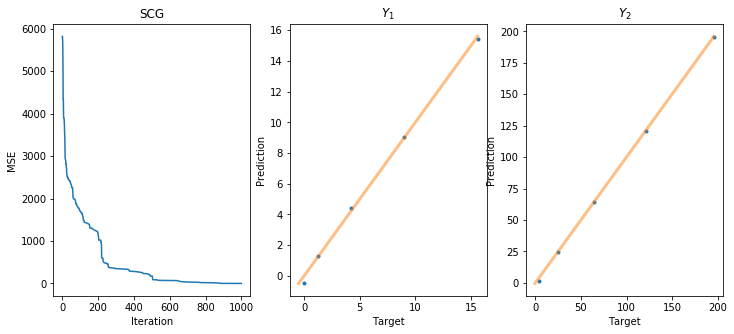

In [21]:
def plot_diagonal(T, Y):
    a = min(T.min(), Y.min())
    b = max(T.max(), Y.max())
    plt.plot([a, b], [a, b], '-', lw=3, alpha=0.5)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(result_scg['ftrace'])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('SCG')

plt.subplot(1, 3, 2)
plt.plot(T[:, 0], Y[:, 0], '.')
plot_diagonal(T[:, 0], Y[:, 0])
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('$Y_1$')

plt.subplot(1, 3, 3)
plt.plot(T[:, 1], Y[:, 1], '.')
plot_diagonal(T[:, 1], Y[: 1])
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('$Y_2$');

<h3>Discussion</h3>
SCG had the best MSE of 0.640 and slowest run time of 0.36 seconds. Based on the first graph (Iterations by MSE) it looks like the right amount of iterations are to reached the minimumize the MSE. However after running the training several times with the randomized initial weights the MSE varies quite a lot suggesting that higher iterations might be needed to consistently get a low MSE. The Y1 graph plots a linear line for the first output which plots very well for all five values. The Y2 graph is identical to the Y1 graph except the range of the x, y axes is now 0-200 instead of 0-15. Y2 seems to plot well with a linear line for all five values. 

When the training results in a higher MSE the Y1 graph plots a linear line for the first output which doesn't plot very well for the last value (15, 13), but well for the first four values. The Y2 graph is identical to the Y1 graph except the range of the x, y axes is now 0-200 instead of 0-15. Y2 seems to plot well with a linear line except for the last value (200, 170).

<h2>Extra Credit</h2>

<h3>Train Model</h3>

In [22]:
hour = [int(t[:2]) for t in data['Time']]
X = np.array(hour).reshape(-1, 1)
CO = data['CO(GT)']
T = np.array(CO).reshape(-1, 1)

n_hiddens_1 = 5
n_hiddens_2 = 5
n_iterations = 3000

n_inputs = X.shape[1]
n_outputs = T.shape[1]

n_U = (n_inputs + 1) * n_hiddens_1
n_V = (n_hiddens_1 + 1) * n_hiddens_2
n_W = (n_hiddens_2 + 1) * n_outputs

initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)  # range of weights is -0.1 to 0.1

result_adam = opt.adam(initial_w, 
                       mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                       n_iterations=n_iterations, learning_rate=1e-2, 
                       save_wtrace=True)
print(f'Adam final error is {result_adam["ftrace"][-1]:.3f} and it took {result_adam["time"]:.2f} seconds')

Adam final error is 0.965 and it took 1.49 seconds


<h3>Plot</h3>

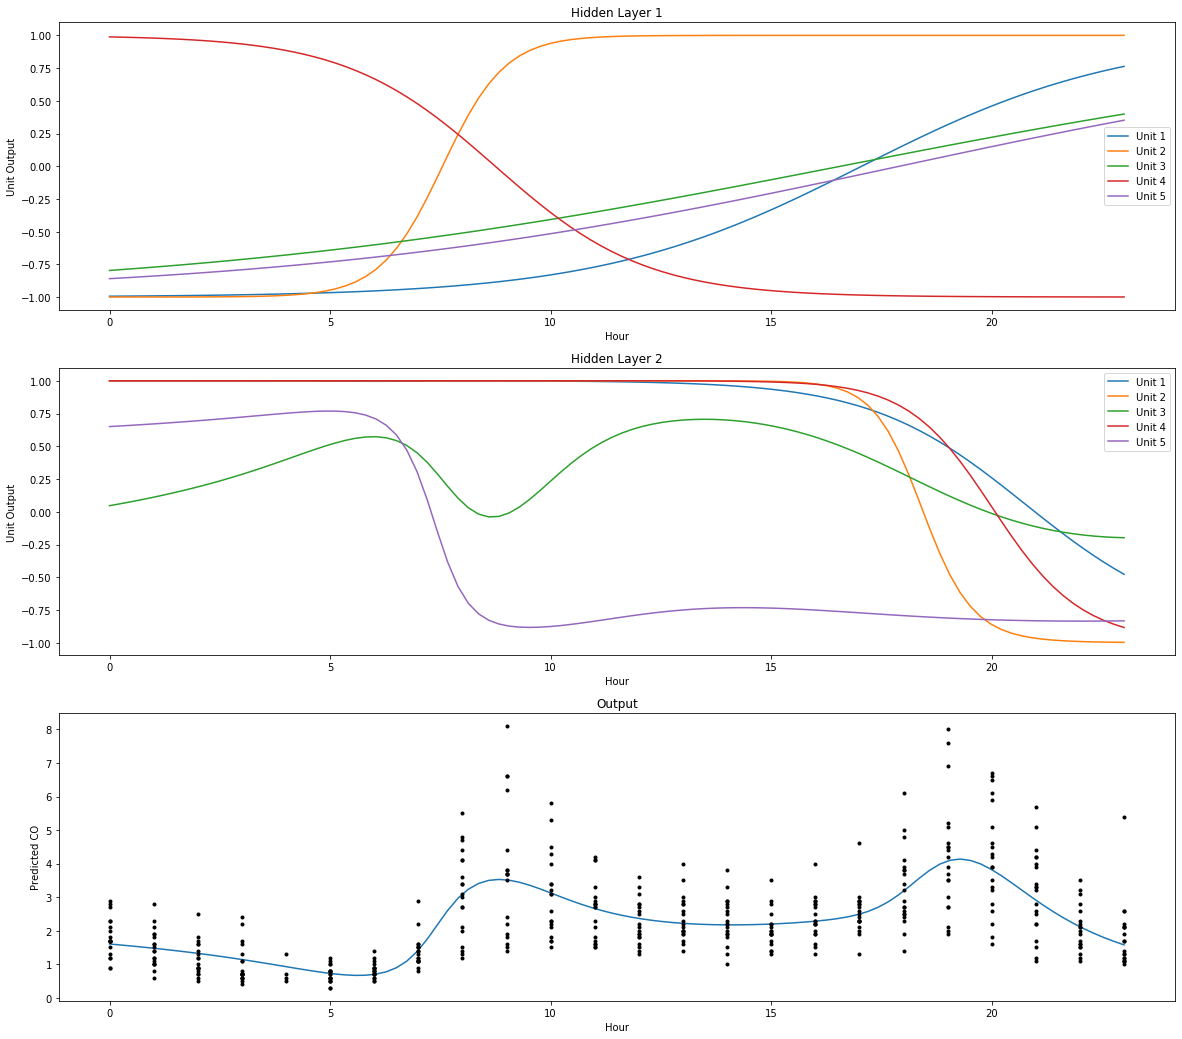

In [23]:
xs_standardized = np.linspace(0, 23, 100).reshape((-1, 1))
Y, Z1, Z2 = network(result_adam['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized, True)

plt.figure(figsize=(20, 18))
plt.subplot(3, 1, 1)
[a, b, c, d, e] = plt.plot(xs, Z1)
plt.title("Hidden Layer 1")
plt.legend([a, b, c, d, e], ["Unit 1", "Unit 2", "Unit 3", "Unit 4", "Unit 5"])
plt.xlabel('Hour')
plt.ylabel('Unit Output')

plt.subplot(3, 1, 2)
plt.title("Hidden Layer 2")
[a, b, c, d, e] = plt.plot(xs, Z2)
plt.legend([a, b, c, d, e], ["Unit 1", "Unit 2", "Unit 3", "Unit 4", "Unit 5"])
plt.xlabel('Hour')
plt.ylabel('Unit Output')

plt.subplot(3, 1, 3)
plt.title("Output")
plt.plot(xs, Y)
plt.plot(X, T, 'k.')
plt.xlabel('Hour')
plt.ylabel('Predicted CO');

<h3>Discussion</h3>
The first plot shows the outputs of the first layer given the hour. They look like different forms of the tanh function. The second plot shows the weights of the second layer. The second layer has a few outputs that look like the tanh function, but a few that are more complex. This makes sense given the second layers inputs are from the first layers outputs (a tanh funtion) that then go into the second layer (a second tanh function) creating a more complex relationship (than a single tanh function) between the input hours and the outputs of the second layer. The final graph shows the predicted output of the final layer. The predicted ouput is a more complex function than the second hidden layer for the same reason the second hidden layer is more complex than the first hidden layer except their is no tanh function on the last layer.

In [1]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Armstrong-A2.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
X = np.arange(3 * 4).reshape((3, 4)) * 0.1
T = np.hstack(( np.sin(X[:, 0:1]) + X[:, 1:2],
                X[:, 2:3] * -0.5,
                X[:, 3:4] ** 2))
n_inputs = X.shape[1]
n_outputs = T.shape[1]
n_hiddens_1 = 6
n_hiddens_2 = 2
n_w = (n_inputs + 1) * n_hiddens_1 + (n_hiddens_1 + 1) * n_hiddens_2 + (n_hiddens_2 + 1) * n_outputs
w = (np.arange(n_w) - n_w/2) * 0.01
Y = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X)


--- 20/20 points. Returned correct values.

Testing
Y, Z1, Z2 = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, all_outputs=True)


--- 20/20 points. Returned correct values.

Testing
grad = error_gradient(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T)


--- 20/20 points. Returned correct